In [1]:
%load_ext autoreload
%autoreload

import scipy.io
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from neuralDecoder.utils.handwritingDataUtils import *

In [2]:
sessionName = 't12.2022.08.25'
featType = 'sp_and_tx'
includeIFG = False
cutEnd = False
heldOutBlocks = False
cumulativeMean = False
rollingMean = False
addMeanDriftNoise = False
useRawRedisData = True
noMeanAdaptation = False
addInterWordSil = True
withinBlockStd = False
realTimeMode = False
partitionSuffix = ''
saveSuffix = ''

In [3]:
if useRawRedisData:
    lrr_mat = scipy.io.loadmat('/home/groups/shenoy/fwillett/speech/rawData/'+sessionName+'_20ms_sentences_raw.mat')
else:
    lrr_mat = scipy.io.loadmat('/home/groups/shenoy/fwillett/speech/rawData/'+sessionName+'_20ms_sentences_lrr.mat')

if cutEnd:
    binsToCut = scipy.io.loadmat('/home/groups/shenoy/fwillett/speech/rawData/'+sessionName+'_binsToRemoveFromEnd.mat')
else:
    binsToCut = []

In [13]:
input_features = []
transcriptions = []
frame_lens = []
block_means = []
block_stds = []
n_trials = lrr_mat['zeroPaddedSentences'].shape[0]

for i in range(n_trials):    
    features = lrr_mat['zeroPaddedSentences'][i]
    
    if cutEnd:
        binsToRemove = binsToCut['binsToRemoveFromEnd'][0, i]-40
        if binsToRemove<0:
            binsToRemove = 0
    else:
        binsToRemove = 0
    
    sentence_len = (lrr_mat['sentenceDurations'][i, 0] - binsToRemove).astype(np.int32)
    if includeIFG:
        features_tx = features[0:sentence_len, 0:256].astype(np.float32)
        features_sp = features[0:sentence_len, 256:512].astype(np.float32)
    else:
        features_tx = features[0:sentence_len, 0:128].astype(np.float32)
        features_sp = features[0:sentence_len, 256:384].astype(np.float32)
    
    sentence = lrr_mat['sentences'][i][0][0]
    
    if featType=='sp_and_tx':
        input_features.append(np.concatenate([features_tx, features_sp], axis=1))
    elif featType=='tx_only':
        input_features.append(features_tx)
        
    transcriptions.append(sentence)
    frame_lens.append(sentence_len)

In [14]:
blockList = np.unique(lrr_mat['blockNum'])
blocks = []
sentBlocks = lrr_mat['blockNum'][lrr_mat['goTrialEpochs'][:,0]]

for b in range(len(blockList)):
    sentIdx = np.argwhere(sentBlocks==blockList[b])
    sentIdx = sentIdx[:,0].astype(np.int32)
    blocks.append(sentIdx)

In [15]:
if heldOutBlocks:
    #hold out block numbers
    ttp = scipy.io.loadmat('/home/groups/shenoy/fwillett/speech/trainTestPartitions_heldOutBlocks/'+sessionName+partitionSuffix+'.mat')

    trainPartitionIdx = []
    trainBlocks = np.squeeze(ttp['trainBlocks'])
    for x in range(len(trainBlocks)):
        blockIdx = np.argwhere(trainBlocks[x]==blockList)
        trainPartitionIdx.append(blocks[blockIdx[0,0]])

    testPartitionIdx = []
    testBlocks = np.squeeze(ttp['testBlocks'])
    if testBlocks.shape==():
        testBlocks = [testBlocks]

    for x in range(len(testBlocks)):
        blockIdx = np.argwhere(testBlocks[x]==blockList)
        testPartitionIdx.append(blocks[blockIdx[0,0]])
        
    trainPartitionIdx = np.concatenate(trainPartitionIdx)
    testPartitionIdx = np.concatenate(testPartitionIdx)
    
else:
    #random held out trials
    #trainPartitionIdx = np.arange(0,520).astype(np.int32)
    #testPartitionIdx = np.arange(520,570).astype(np.int32)

    ttp = scipy.io.loadmat('/home/groups/shenoy/fwillett/speech/trainTestPartitions/'+sessionName+partitionSuffix+'.mat')
    trainPartitionIdx = np.squeeze(ttp['trainTrials'])
    testPartitionIdx = np.squeeze(ttp['testTrials'])

print(trainPartitionIdx)
print(testPartitionIdx)

#trlShuff = np.concatenate([np.arange(0,140).astype(np.int32), np.arange(190,250).astype(np.int32)])
#np.random.shuffle(trlShuff)

#trainPartitionIdx=trlShuff[0:-20]
#testPartitionIdx=trlShuff[-20:]

#trainPartitionIdx = np.arange(140,190).astype(np.int32)
#testPartitionIdx = np.arange(140,190).astype(np.int32)

[ 40 241 433 220 289 321 147 380 383   0 106 176 368  92 384 366  44 346
 397 419 129 111 337 248 343 287 396 148 233 140 388 193 441 139 255 136
 322  43  51 234 404 190 126 342 349 353 109 141  84 462 431  76 459 274
 105  98 323 150 247  24  82  29  61 282 334 417 276  77  35 166 429 134
  89 426 272 312 178 132   4 151  21 259 391  32 361  80 191 475 425 206
 224 237 125 172  22 422 439 387 250 451 223 225 123 278 195 454 364  31
 235 403 443 474 240 369 479 197 358 184 263 347 418 169 219 376 238 305
 264 135 435 356 372 200 336 256 447 331 165 286 218  96 476 362  19  79
  55  12 268  46 158 460  91 386  95  42 230  50 405 415 326  71 204 406
  66 203  59 194 317 100  58  17  36 470 108   5  37 265 297  60 427 199
 466 325 382 448 124 209 152 463 104 284 103 375 352 424 314 149   2 311
 138 440 227 164 177 267   7  72 137 180 116  62 421 192  18 469 477 258
 293 408  75 187 365 373 461 182 254 275 196  97 179 117 183 273 231  54
 468  90  14 144  33 332 374 304 171 207 221 446 30

In [16]:
if realTimeMode:
    input_features_raw = input_features.copy()
    for b in range(len(blocks)):
        if b==0:
            feats = np.concatenate(input_features_raw[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
            feats_mean = np.mean(feats, axis=0, keepdims=True)
            feats_std = np.std(feats, axis=0, keepdims=True)

            for i in blocks[b]:
                input_features[i] = (input_features[i] - feats_mean) / feats_std 
        else:
            feats = np.concatenate(input_features_raw[blocks[b-1][0]:(blocks[b-1][-1]+1)], axis=0)
            start_mean = np.mean(feats, axis=0, keepdims=True)
            start_std = np.std(feats, axis=0, keepdims=True)        

            sentIdx = 0
            for i in blocks[b]:
                nSentMin = 10
                nSentMax = 20
                sentIdx += 1
                nToTake = min(sentIdx-1, nSentMax)

                if sentIdx==1:
                    meanToUse = start_mean
                    stdToUse = start_std
                elif nToTake<nSentMin:
                    feats = np.concatenate(input_features_raw[(i-nToTake):i], axis=0)
                    feats_mean = np.mean(feats, axis=0, keepdims=True)
                    feats_std = np.std(feats, axis=0, keepdims=True)

                    meanToUse = (feats_mean * nToTake + start_mean * (nSentMin - nToTake)) / nSentMin
                    stdToUse = (feats_std * nToTake + start_std * (nSentMin - nToTake)) / nSentMin
                else:
                    feats = np.concatenate(input_features_raw[(i-nToTake):i], axis=0)
                    meanToUse = np.mean(feats, axis=0, keepdims=True)
                    stdToUse = np.std(feats, axis=0, keepdims=True)

                input_features[i] = (input_features[i] - meanToUse) / stdToUse
                input_features[i][input_features[i]<-10]=0
                input_features[i][input_features[i]>10]=0
                
elif heldOutBlocks and not noMeanAdaptation:
    input_features_raw = input_features.copy()
    
    if cumulativeMean:
        candidateBlocks = np.concatenate([trainBlocks, testBlocks])
    else:
        candidateBlocks = trainBlocks
            
    #compute block-specific means and mean-sbutract the training blocks
    allMeans = []
    if_train = []
    for b in range(len(candidateBlocks)):
        blockIdx = np.argwhere(candidateBlocks[b]==blockList)
        blockIdx = blockIdx[0,0]

        feats = np.concatenate(input_features[blocks[blockIdx][0]:(blocks[blockIdx][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        allMeans.append(feats_mean)
        
        if np.any(candidateBlocks[b]==testBlocks):
            continue
            
        for i in blocks[blockIdx]:
            input_features[i] = (input_features[i] - feats_mean) #/ (feats_std + 1e-8)
            if_train.append(input_features[i])

    all_std = np.std(np.concatenate(if_train, axis=0), axis=0, keepdims=True) + 1e-8
    #all_std = np.std(np.concatenate(input_features, axis=0), axis=0, keepdims=True) + 1e-8
    
    #mean-subtract the testing blocks with the closest available prior block
    for b in range(len(testBlocks)):
        blockIdx = np.argwhere(testBlocks[b]==blockList)
        blockIdx = blockIdx[0,0]
   
        validBlocks = candidateBlocks[candidateBlocks<testBlocks[b]] 
        meanBlockIdx = validBlocks[-1]
        meanBlockIdx = np.argwhere(meanBlockIdx==candidateBlocks)
        meanBlockIdx = meanBlockIdx[0,0]
        
        sentIdx = 0
        for i in blocks[blockIdx]:
            #rolling mean, take from the last 5 sentences
            nSentMin = 10
            nSentMax = 20
            sentIdx += 1
            if sentIdx>nSentMin and rollingMean:
                nToTake = min(sentIdx-1, nSentMax)
                feats = np.concatenate(input_features_raw[(i-nToTake):i], axis=0)
                feats_mean = np.mean(feats, axis=0, keepdims=True)
                meanToSubtract = feats_mean
            else:
                meanToSubtract = allMeans[meanBlockIdx]
        
            input_features[i] = (input_features[i] - meanToSubtract)

    for i in range(len(input_features)):
        input_features[i] = input_features[i] / all_std
        
    #clipping?
    #for i in range(len(input_features)):
    #    input_features[i][input_features[i]>10]=0
    #    input_features[i][input_features[i]<-10]=0
        
    if addMeanDriftNoise:
        for b in range(len(testBlocks)):
            blockIdx = np.argwhere(testBlocks[b]==blockList)
            blockIdx = blockIdx[0,0]

            for i in blocks[blockIdx]:
                meanDirftNoise = np.random.randn(1,input_features[0].shape[1])*0.6
                input_features[i] = (input_features[i] + meanDirftNoise)        
        
elif not noMeanAdaptation:
    for b in range(len(blocks)):
        feats = np.concatenate(input_features[blocks[b][0]:(blocks[b][-1]+1)], axis=0)
        feats_mean = np.mean(feats, axis=0, keepdims=True)
        feats_std = np.std(feats, axis=0, keepdims=True)
        for i in blocks[b]:
            if withinBlockStd:
                input_features[i] = (input_features[i] - feats_mean) / (feats_std + 1e-8)
            else:
                input_features[i] = (input_features[i] - feats_mean) #/ (feats_std + 1e-8)

    trialsToUse = np.concatenate([trainPartitionIdx, testPartitionIdx])
    ifToUse = []
    
    for t in trialsToUse:
        ifToUse.append(input_features[t])
    
    if not withinBlockStd:
        all_std = np.std(np.concatenate(ifToUse, axis=0), axis=0, keepdims=True) + 1e-8
        for i in range(len(input_features)):
            input_features[i] = input_features[i] / all_std
    

['W', 'IY', 'SIL', 'JH', 'AH', 'S', 'T', 'SIL', 'HH', 'AE', 'D', 'SIL', 'AH', 'SIL', 'B', 'AO', 'L', 'SIL']
we just had a ball
[36 18 40 19  3 29 31 40 16  2]
['W', 'EH', 'N', 'SIL', 'AY', 'SIL', 'K', 'AH', 'M', 'SIL', 'B', 'AE', 'K', 'SIL', 'T', 'UW', 'SIL', 'M', 'AY', 'SIL', 'S', 'IY', 'T', 'SIL']
when i come back to my seat
[36 11 23 40  6 40 20  3 22 40]
['AY', 'SIL', 'W', 'UH', 'D', 'SIL', 'TH', 'IH', 'NG', 'K', 'SIL', 'DH', 'AE', 'T', 'SIL', 'IH', 'T', 'S', 'SIL', 'AH', 'SIL', 'P', 'R', 'IH', 'T', 'IY', 'SIL', 'K', 'AA', 'M', 'SIL', 'S', 'IH', 'T', 'IY', 'SIL']
i would think that it's a pretty calm city
[ 6 40 36 33  9 40 32 17 24 20]
['AY', 'SIL', 'D', 'OW', 'N', 'T', 'SIL', 'HH', 'AE', 'V', 'SIL', 'AH', 'SIL', 'S', 'P', 'R', 'IH', 'NG', 'K', 'L', 'ER', 'SIL', 'S', 'IH', 'S', 'T', 'AH', 'M', 'SIL']
i don't have a sprinkler system
[ 6 40  9 25 23 31 40 16  2 35]
['DH', 'OW', 'Z', 'SIL', 'AA', 'R', 'SIL', 'R', 'AH', 'N', 'IH', 'NG', 'SIL']
those are running
[10 25 38 40  1 28 40 2

['DH', 'IH', 'S', 'SIL', 'W', 'UH', 'M', 'AH', 'N', 'SIL', 'JH', 'AH', 'S', 'T', 'SIL', 'AO', 'F', 'ER', 'D', 'SIL', 'IH', 'T', 'SIL', 'T', 'UW', 'SIL', 'M', 'IY', 'SIL']
this woman just offered it to me
[10 17 29 40 36 33 22  3 23 40]
['D', 'UW', 'SIL', 'Y', 'UW', 'SIL', 'P', 'L', 'EY', 'SIL', 'DH', 'AH', 'SIL', 'P', 'IY', 'AE', 'N', 'OW', 'SIL']
do you play the piano
[ 9 34 40 37 34 40 27 21 13 40]
['Y', 'UW', 'SIL', 'K', 'AE', 'N', 'SIL', 'P', 'IH', 'K', 'SIL', 'W', 'AH', 'T', 'SIL', 'Y', 'UW', 'SIL', 'W', 'AA', 'N', 'T', 'SIL']
you can pick what you want
[37 34 40 20  2 23 40 27 17 20]
['D', 'UW', 'SIL', 'Y', 'UW', 'SIL', 'HH', 'AE', 'V', 'SIL', 'T', 'UW', 'SIL', 'P', 'EY', 'SIL', 'F', 'AO', 'R', 'SIL', 'DH', 'AE', 'T', 'SIL']
do you have to pay for that
[ 9 34 40 37 34 40 16  2 35 40]
['W', 'IY', 'R', 'SIL', 'B', 'OW', 'TH', 'SIL', 'S', 'K', 'UW', 'L', 'SIL', 'T', 'IY', 'CH', 'ER', 'Z', 'SIL']
we're both school teachers
[36 18 28 40  7 25 32 40 29 20]
['T', 'UW', 'SIL', 'TH', 'AW'

['DH', 'EH', 'R', 'Z', 'SIL', 'AH', 'N', 'AH', 'DH', 'ER', 'SIL', 'AE', 'S', 'P', 'EH', 'K', 'T', 'SIL', 'AH', 'V', 'SIL', 'DH', 'IH', 'S', 'SIL']
there's another aspect of this
[10 11 28 38 40  3 23  3 10 12]
['Y', 'UH', 'R', 'SIL', 'AH', 'L', 'ER', 'T', 'SIL', 'F', 'AO', 'R', 'SIL', 'DH', 'AH', 'SIL', 'K', 'IH', 'D', 'SIL', 'HH', 'UW', 'Z', 'SIL', 'V', 'EH', 'R', 'IY', 'SIL', 'D', 'R', 'AW', 'Z', 'IY', 'SIL']
you're alert for the kid who's very drowsy
[37 33 28 40  3 21 12 31 40 14]
['IH', 'T', 'S', 'SIL', 'AA', 'N', 'SIL', 'D', 'AW', 'N', 'SIL', 'DH', 'AH', 'SIL', 'L', 'AY', 'N', 'SIL']
it's on down the line
[17 31 29 40  1 23 40  9  5 23]
['AE', 'F', 'T', 'ER', 'SIL', 'DH', 'EY', 'V', 'SIL', 'G', 'AO', 'N', 'SIL', 'AH', 'N', 'D', 'SIL', 'D', 'AH', 'N', 'SIL', 'HH', 'AO', 'R', 'AH', 'B', 'AH', 'L', 'SIL', 'TH', 'IH', 'NG', 'Z', 'SIL']
after they've gone and done horrible things
[ 2 14 31 12 40 10 13 35 40 15]
['AE', 'T', 'SIL', 'DH', 'AH', 'SIL', 'K', 'R', 'AE', 'F', 'T', 'SIL', 'SH

['AY', 'V', 'SIL', 'N', 'EH', 'V', 'ER', 'SIL', 'B', 'IH', 'N', 'SIL', 'AH', 'P', 'SIL', 'DH', 'EH', 'R', 'SIL']
i've never been up there
[ 6 35 40 23 11 35 12 40  7 17]
['M', 'EH', 'N', 'T', 'AH', 'L', 'SIL', 'AH', 'K', 'Y', 'UW', 'AH', 'T', 'IY', 'SIL', 'IH', 'Z', 'SIL', 'IY', 'Z', 'IY', 'SIL', 'T', 'UW', 'SIL', 'S', 'AH', 'S', 'T', 'EY', 'N', 'SIL']
mental acuity is easy to sustain
[22 11 23 31  3 21 40  3 20 37]
['DH', 'EY', 'SIL', 'W', 'UH', 'D', 'SIL', 'HH', 'AE', 'V', 'SIL', 'B', 'IH', 'N', 'SIL', 'EY', 'B', 'AH', 'L', 'SIL', 'T', 'UW', 'SIL', 'F', 'AY', 'N', 'D', 'SIL', 'HH', 'IH', 'M', 'SIL']
they would have been able to find him
[10 13 40 36 33  9 40 16  2 35]
['AY', 'SIL', 'W', 'AA', 'Z', 'SIL', 'G', 'OW', 'IH', 'NG', 'SIL', 'T', 'UW', 'SIL', 'D', 'UW', 'SIL', 'IH', 'T', 'SIL']
i was going to do it
[ 6 40 36  1 38 40 15 25 17 24]
['HH', 'IY', 'SIL', 'W', 'EH', 'N', 'T', 'SIL', 'T', 'UW', 'SIL', 'M', 'UW', 'V', 'SIL', 'IH', 'N', 'SIL', 'W', 'IH', 'DH', 'SIL', 'AH', 'N', 'AH',

[16 12 40  7  1  9 18 40 36  1]
['AY', 'SIL', 'HH', 'AE', 'D', 'SIL', 'HH', 'ER', 'D', 'SIL', 'AH', 'SIL', 'K', 'AH', 'P', 'AH', 'L', 'SIL', 'AH', 'V', 'SIL', 'P', 'IY', 'P', 'AH', 'L', 'SIL']
i had heard a couple of people
[ 6 40 16  2  9 40 16 12  9 40]
['D', 'AE', 'L', 'AH', 'S', 'SIL', 'HH', 'AE', 'Z', 'SIL', 'AH', 'SIL', 'G', 'AY', 'SIL']
dallas has a guy
[ 9  2 21  3 29 40 16  2 38 40]
['HH', 'IH', 'Z', 'SIL', 'D', 'AE', 'D', 'IY', 'SIL', 'OW', 'N', 'D', 'SIL', 'AH', 'SIL', 'B', 'OW', 'T', 'SIL', 'SH', 'AA', 'P', 'SIL']
his daddy owned a boat shop
[16 17 38 40  9  2  9 18 40 25]
['AY', 'SIL', 'G', 'EH', 'S', 'SIL', 'DH', 'IH', 'S', 'SIL', 'IH', 'Z', 'SIL', 'Y', 'AO', 'R', 'SIL', 'F', 'ER', 'S', 'T', 'SIL', 'T', 'AY', 'M', 'SIL', 'T', 'UW', 'SIL', 'B', 'AY', 'SIL', 'AH', 'M', 'EH', 'R', 'AH', 'K', 'AH', 'N', 'SIL']
i guess this is your first time to buy american
[ 6 40 15 11 29 40 10 17 29 40]
['T', 'UW', 'SIL', 'K', 'IH', 'L', 'SIL', 'S', 'AH', 'M', 'B', 'AA', 'D', 'IY', 'SIL', '

['HH', 'IY', 'Z', 'SIL', 'R', 'AH', 'N', 'SIL', 'IH', 'N', 'T', 'UW', 'SIL', 'S', 'OW', 'SIL', 'M', 'EH', 'N', 'IY', 'SIL', 'P', 'R', 'AA', 'B', 'L', 'AH', 'M', 'Z', 'SIL']
he's run into so many problems
[16 18 38 40 28  3 23 40 17 23]
['DH', 'EY', 'L', 'SIL', 'HH', 'AE', 'V', 'SIL', 'DH', 'IY', 'Z', 'SIL', 'L', 'IH', 'T', 'AH', 'L', 'SIL', 'P', 'AA', 'R', 'T', 'IY', 'Z', 'SIL']
they'll have these little parties
[10 13 21 40 16  2 35 40 10 18]
['AY', 'SIL', 'D', 'OW', 'N', 'T', 'SIL', 'N', 'OW', 'SIL', 'W', 'AY', 'SIL', 'AY', 'SIL', 'N', 'EH', 'V', 'ER', 'SIL', 'R', 'EH', 'JH', 'IH', 'S', 'T', 'ER', 'D', 'SIL', 'IH', 'T', 'SIL']
i don't know why i never registered it
[ 6 40  9 25 23 31 40 23 25 40]
['HH', 'AW', 'SIL', 'D', 'UW', 'SIL', 'Y', 'UW', 'SIL', 'Y', 'UW', 'ZH', 'AH', 'W', 'AH', 'L', 'IY', 'SIL', 'IY', 'T', 'SIL', 'IH', 'T', 'SIL']
how do you usually eat it
[16  5 40  9 34 40 37 34 40 37]
['IH', 'T', 'S', 'SIL', 'DH', 'AH', 'SIL', 'TH', 'ER', 'D', 'IY', 'SIL', 'F', 'AY', 'V', '

['DH', 'EY', 'SIL', 'W', 'ER', 'SIL', 'SH', 'OW', 'IH', 'NG', 'SIL', 'S', 'AH', 'M', 'SIL', 'AH', 'N', 'D', 'SIL', 'AY', 'SIL', 'W', 'AA', 'Z', 'SIL', 'W', 'AA', 'CH', 'IH', 'NG', 'SIL']
they were showing some and i was watching
[10 13 40 36 12 40 30 25 17 24]
['HH', 'IY', 'SIL', 'W', 'AA', 'Z', 'SIL', 'AH', 'SIL', 'K', 'ER', 'IY', 'ER', 'SIL']
he was a courier
[16 18 40 36  1 38 40  3 40 20]
['IH', 'N', 'SIL', 'DH', 'AH', 'SIL', 'P', 'AH', 'N', 'IH', 'SH', 'M', 'AH', 'N', 'T', 'SIL', 'F', 'EY', 'Z', 'SIL']
in the punishment phase
[17 23 40 10  3 40 27  3 23 17]
['W', 'AH', 'T', 'SIL', 'D', 'UW', 'SIL', 'Y', 'UW', 'SIL', 'F', 'AY', 'N', 'D', 'SIL', 'DH', 'AE', 'T', 'SIL', 'Y', 'UW', 'SIL', 'Y', 'UW', 'Z', 'SIL', 'Y', 'UH', 'R', 'Z', 'SIL', 'M', 'OW', 'S', 'T', 'L', 'IY', 'SIL', 'F', 'AO', 'R', 'SIL']
what do you find that you use yours mostly for
[36  3 31 40  9 34 40 37 34 40]
['EH', 'M', 'P', 'L', 'OY', 'IY', 'Z', 'SIL', 'W', 'IH', 'L', 'SIL', 'N', 'AA', 'T', 'SIL', 'G', 'EH', 'T', '

['W', 'AH', 'T', 'SIL', 'AY', 'SIL', 'HH', 'AE', 'V', 'SIL', 'T', 'UW', 'SIL', 'D', 'UW', 'SIL']
what i have to do
[36  3 31 40  6 40 16  2 35 40]
['AO', 'R', 'SIL', 'AH', 'SIL', 'R', 'OW', 'SIL', 'AH', 'V', 'SIL', 'S', 'IY', 'T', 'S', 'SIL', 'AE', 'K', 'CH', 'AH', 'W', 'AH', 'L', 'IY', 'SIL']
or a row of seats actually
[ 4 28 40  3 40 28 25 40  3 35]
['AH', 'SIL', 'N', 'UW', 'SIL', 'EH', 'M', 'P', 'L', 'OY', 'IY', 'SIL', 'EH', 'V', 'ER', 'IY', 'SIL', 'S', 'IH', 'K', 'S', 'SIL', 'M', 'AH', 'N', 'TH', 'S', 'SIL']
a new employee every six months
[ 3 40 23 34 40 11 22 27 21 26]
['IH', 'T', 'SIL', 'G', 'IH', 'V', 'Z', 'SIL', 'M', 'IY', 'SIL', 'N', 'OW', 'SIL', 'P', 'L', 'EH', 'ZH', 'ER', 'SIL', 'T', 'UW', 'SIL', 'S', 'IY', 'SIL', 'EH', 'N', 'IY', 'W', 'AH', 'N', 'SIL', 'S', 'T', 'R', 'AH', 'G', 'AH', 'L', 'SIL']
it gives me no pleasure to see anyone struggle
[17 31 40 15 17 35 38 40 22 18]
['IH', 'T', 'S', 'SIL', 'AE', 'N', 'SIL', 'IH', 'N', 'T', 'R', 'AH', 'S', 'T', 'IH', 'NG', 'SIL', 'JH

['T', 'EH', 'L', 'AH', 'V', 'IH', 'ZH', 'AH', 'N', 'SIL', 'IH', 'Z', 'SIL', 'M', 'AY', 'SIL', 'M', 'EY', 'N', 'SIL', 'N', 'UW', 'Z', 'SIL', 'S', 'AO', 'R', 'S', 'SIL']
television is my main news source
[31 11 21  3 35 17 39  3 23 40]
['DH', 'EY', 'SIL', 'HH', 'OW', 'L', 'D', 'SIL', 'IH', 'T', 'SIL', 'AH', 'P', 'SIL', 'T', 'UW', 'SIL', 'DH', 'AH', 'SIL', 'S', 'AH', 'N', 'SIL', 'G', 'AA', 'D', 'SIL']
they hold it up to the sun god
[10 13 40 16 25 21  9 40 17 31]
['IH', 'T', 'S', 'SIL', 'HH', 'AA', 'R', 'D', 'SIL', 'W', 'IH', 'DH', 'SIL', 'T', 'UW', 'SIL']
it's hard with two
[17 31 29 40 16  1 28  9 40 36]
['W', 'EH', 'DH', 'ER', 'SIL', 'IH', 'T', 'S', 'SIL', 'AH', 'SIL', 'M', 'ER', 'D', 'ER', 'SIL', 'K', 'EY', 'S', 'SIL']
whether it's a murder case
[36 11 10 12 40 17 31 29 40  3]
['JH', 'AH', 'S', 'T', 'SIL', 'B', 'IH', 'K', 'AO', 'Z', 'SIL', 'IH', 'T', 'SIL', 'OW', 'N', 'L', 'IY', 'SIL', 'T', 'EY', 'K', 'S', 'SIL', 'AH', 'SIL', 'F', 'Y', 'UW', 'SIL', 'M', 'IH', 'N', 'AH', 'T', 'S', 'SIL

['IH', 'T', 'S', 'SIL', 'HH', 'AA', 'R', 'D', 'SIL', 'F', 'AO', 'R', 'SIL', 'M', 'IY', 'SIL', 'T', 'UW', 'SIL']
it's hard for me to
[17 31 29 40 16  1 28  9 40 14]
['DH', 'IH', 'S', 'SIL', 'P', 'L', 'IY', 'SIL', 'B', 'AA', 'R', 'G', 'IH', 'N', 'IH', 'NG', 'SIL', 'B', 'AH', 'L', 'OW', 'N', 'IY', 'SIL']
this plea bargaining baloney
[10 17 29 40 27 21 18 40  7  1]
['N', 'OW', 'SIL', 'DH', 'EH', 'R', 'Z', 'SIL', 'N', 'OW', 'SIL', 'W', 'EY', 'SIL']
no there's no way
[23 25 40 10 11 28 38 40 23 25]
['F', 'R', 'AH', 'M', 'SIL', 'Y', 'AO', 'R', 'SIL', 'P', 'OY', 'N', 'T', 'SIL', 'AH', 'V', 'SIL', 'V', 'Y', 'UW', 'SIL']
from your point of view
[14 28  3 22 40 37  4 28 40 27]
['P', 'R', 'AA', 'B', 'L', 'AH', 'M', 'Z', 'SIL', 'DH', 'AE', 'T', 'SIL', 'M', 'EH', 'N', 'SIL', 'HH', 'AE', 'V', 'SIL', 'IH', 'N', 'SIL', 'DH', 'AH', 'SIL', 'R', 'EH', 'L', 'M', 'SIL', 'AH', 'V', 'SIL', 'K', 'AE', 'N', 'S', 'ER', 'SIL']
problems that men have in the realm of cancer
[27 28  1  7 21  3 22 38 40 10]
['IH', 'T

[ 6 40 19  3 29 31 40  9 34 40]
['W', 'IY', 'SIL', 'F', 'AW', 'N', 'D', 'SIL', 'AH', 'SIL', 'R', 'IY', 'L', 'SIL', 'G', 'UH', 'D', 'SIL', 'IH', 'N', 'T', 'R', 'AH', 'S', 'T', 'SIL', 'R', 'EY', 'T', 'SIL']
we found a real good interest rate
[36 18 40 14  5 23  9 40  3 40]
['HH', 'IY', 'Z', 'SIL', 'AE', 'N', 'SIL', 'IH', 'N', 'T', 'R', 'AH', 'S', 'T', 'IH', 'NG', 'SIL', 'P', 'ER', 'S', 'AH', 'N', 'SIL']
he's an interesting person
[16 18 38 40  2 23 40 17 23 31]
['IH', 'N', 'T', 'ER', 'S', 'T', 'EY', 'T', 'SIL', 'D', 'R', 'AY', 'V', 'IH', 'NG', 'SIL']
interstate driving
[17 23 31 12 29 31 13 31 40  9]
['AY', 'SIL', 'HH', 'OW', 'P', 'SIL', 'Y', 'UW', 'SIL', 'G', 'AY', 'Z', 'SIL', 'EH', 'N', 'JH', 'OY', 'SIL', 'IH', 'T', 'SIL']
i hope you guys enjoy it
[ 6 40 16 25 27 40 37 34 40 15]
['AH', 'B', 'AW', 'T', 'SIL', 'AH', 'SIL', 'K', 'W', 'AO', 'R', 'T', 'ER', 'SIL', 'EY', 'K', 'ER', 'SIL', 'AH', 'V', 'SIL', 'DH', 'AE', 'T', 'SIL']
about a quarter acre of that
[ 3  7  5 31 40  3 40 20 36  4]
[

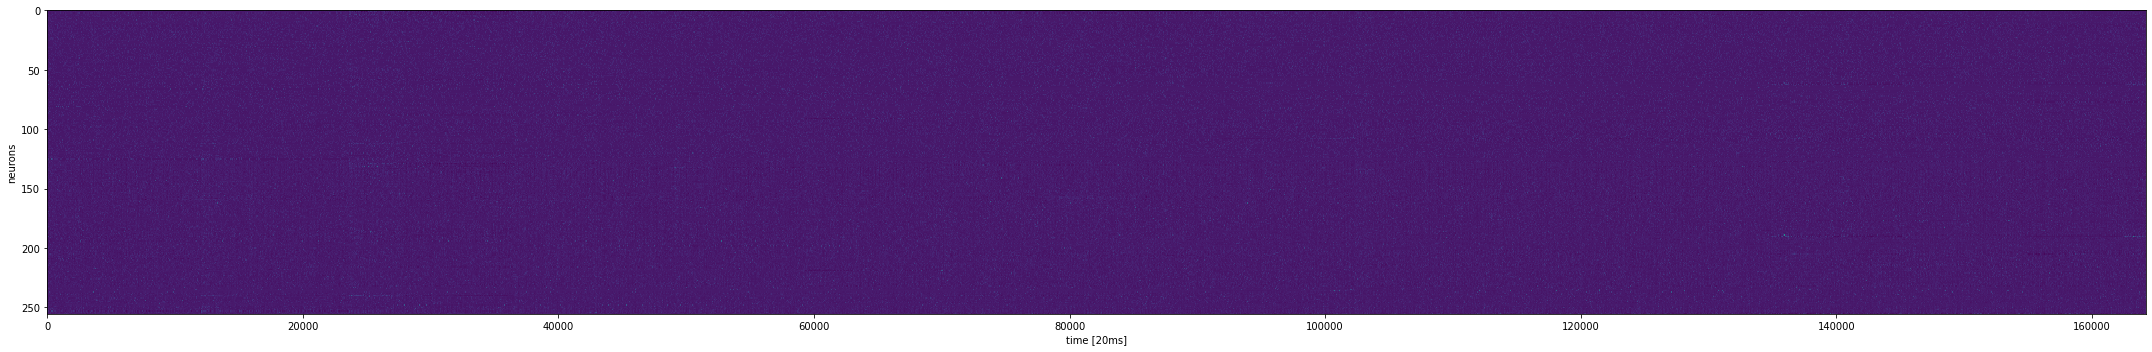

In [17]:
plt.figure(figsize=(30, 5))
plt.imshow(np.concatenate(input_features, 0).T, aspect='auto',
           interpolation='none')
plt.ylabel('neurons')
plt.xlabel('time [20ms]')
plt.tight_layout()

session_data = {
    'inputFeatures': input_features,
    'transcriptions': transcriptions,
    'frameLens': frame_lens
}

if featType=='sp_and_tx':
    suffix='spikePow'
elif featType=='tx_only':
    suffix='txOnly'
    
if includeIFG:
    suffix+='_ifg'

if not cutEnd:
    suffix+='_noCut'
    
if heldOutBlocks:
    suffix+='_heldOutBlocks'

if addMeanDriftNoise:
    suffix += '_mdNoise'
    
if useRawRedisData:
    suffix += '_rawRedis'

if cumulativeMean:
    suffix += '_cMean'
    
if rollingMean:
    suffix +='_rMean'
    
if noMeanAdaptation:
    suffix += '_noZScore'
    
if addInterWordSil:
    suffix += '_iwSil'
    
if withinBlockStd:
    suffix += '_wStd'
    
if realTimeMode:
    suffix += '_rtMode'
    
suffix += partitionSuffix
suffix += saveSuffix

fileName = '/home/groups/shenoy/fwillett/speech/tfData/'+sessionName+'_'+suffix
convertToTFRecord(session_data, 
                  fileName,
                  trainTrials=trainPartitionIdx, 
                  testTrials=testPartitionIdx,
                  convertToPhonemes=True, vowelOnly=False, consonantOnly=False, addInterWordSymbol=addInterWordSil)

In [18]:
print(fileName)

/home/groups/shenoy/fwillett/speech/tfData/t12.2022.08.25_spikePow_noCut_rawRedis_iwSil


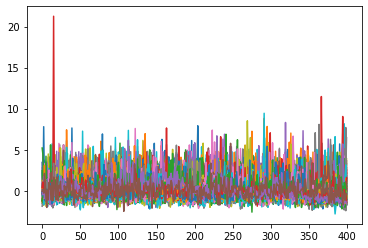

In [28]:
plt.figure()
plt.plot( input_features[420] )
plt.show()

In [10]:
len(input_features)

570

In [11]:
from g2p_en import G2p
g2p = G2p()
g2p("jazzercise")

['JH', 'AE1', 'Z', 'ER0', 'S', 'AY2', 'Z']